In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=0.5)
from fast_pareto import is_pareto_front
from IPython import display
import pickle as pkl
display.clear_output()
from utils import (
    get_model,
    get_dataset,
    get_encoder,
    get_search_space_size,
    get_config_space,
    get_strat,
    radar_factory
)
from sklearn.model_selection import StratifiedKFold
from scipy.stats import percentileofscore, pearsonr, kendalltau, linregress
from scipy.special import kl_div, rel_entr, softmax
import matplotlib.patches as patches
from sklearn.preprocessing import minmax_scale
from pygmo import nadir, ideal, hypervolume
from loguru import logger
from sklearn.inspection import PartialDependenceDisplay
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D
from fanova import fANOVA
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from sklearn.inspection import permutation_importance

2023-08-15 13:06:15.051 | INFO     | MOHPOBenchExperimentUtils:<module>:20 - Import MOHPOBenchExperimentUtils.


In [2]:
model_names, dataset_names = ['xgb', 'rf', 'nn'], ['german', 'compas', 'lawschool', 'bank', 'adult']
seeds = 10

workspace = '/work/dlclarge2/robertsj-fairmohpo'
with open(f'{workspace}/experiments.pkl', 'rb') as f:
    mo_experiments = pkl.load(f)

with open(f'{workspace}/experiments_comp.pkl', 'rb') as f:
    many_experiments = pkl.load(f)

In [3]:
obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd', 'f1_multi']
for model in model_names:
    for dataset in dataset_names:
        for obj_name in obj_names:
            print(model, dataset, obj_name)

            for seed in range(10):
                observations = mo_experiments[(obj_name, model, dataset)][str(seed)]['observations']
                
                print(len(observations))

xgb german f1_ddsp
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb german f1_deod
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb german f1_deop
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb german f1_invd
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb german f1_multi
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb compas f1_ddsp
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb compas f1_deod
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb compas f1_deop
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb compas f1_invd
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb compas f1_multi
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb lawschool f1_ddsp
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb lawschool f1_deod
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb lawschool f1_deop
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb lawschool f1_invd
1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
xgb lawschool f1_mul

## **[RQ 1]:** Fairness Objective Landscape

### Measuring Fairness Metric Contrastiveness

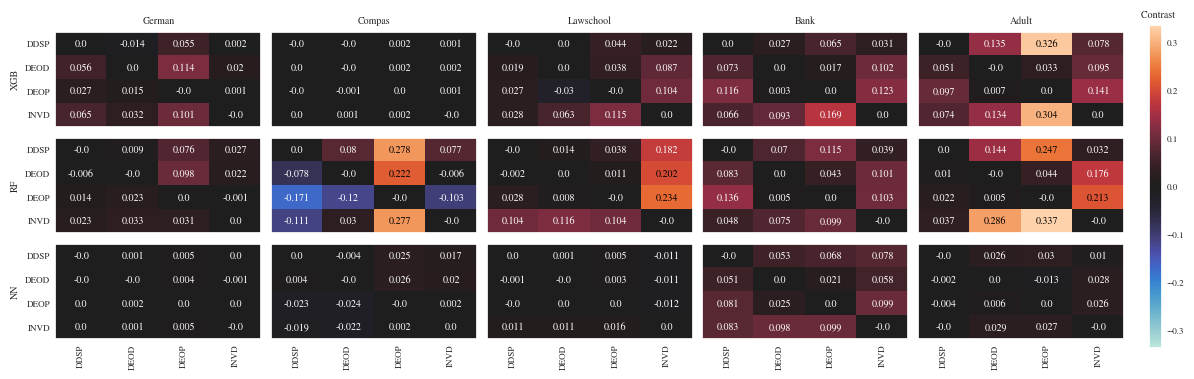

In [4]:
sns.set(font_scale=0.6)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=len(model_names), ncols=len(dataset_names), figsize=(2.5*len(dataset_names), 1.25*len(model_names)))

if len(model_names) == 1:
    axes = [axes]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette()

differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))
for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):

        difference = np.zeros((len(obj_names), len(obj_names)))

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names):
                    
                # if obj_name1 == obj_name2:
                #     difference[k1][k2] = np.nan
                #     continue

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]

                obj_observations2 = mo_experiments[(obj_name2, model, dataset)]['function_values'][val_keys+test_keys]

                both_observations = pd.concat([obj_observations1, obj_observations2])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(obj_observations1[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}']].values)
                est_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                difference[k1][k2] = true_hvol - est_hvol

        differences[i][j] = difference    

for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names): 

        im = axes[i][j].imshow(differences[i][j], vmin=-np.nanmax(differences), vmax=np.nanmax(differences), cmap='icefire', aspect='auto')

        for k1, obj_name2 in enumerate(obj_names):
            for k2, obj_name2 in enumerate(obj_names):
                text = axes[i][j].text(k2, k1, np.around(differences[i][j], decimals=3)[k1][k2],
                       ha="center", va="center", color='black' if np.abs(differences[i][j][k1][k2]) > 0.2 else 'white')
        
        if i == 0:
            axes[i][j].set_title(f"{dataset.capitalize()}")
        
        if i == len(model_names)-1:
            axes[i][j].set_xticks(range(len(obj_names)))
            axes[i][j].set_xticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names], rotation=90)
        else:
            axes[i][j].set_xticks([])            
        if j == 0:
            axes[i][j].set_yticks(range(len(obj_names)))
            axes[i][j].set_yticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names])
            axes[i][j].set_ylabel(model.upper())
        else:
            axes[i][j].set_yticks([])
        
        axes[i][j].tick_params(which='both', size=0)
        axes[i][j].grid(False)

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.86])
cbar = fig.colorbar(im, cbar_ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(which='both', size=0)
cbar.ax.set_title('  Contrast')

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq1/2D_pareto_loss.png', dpi=600)

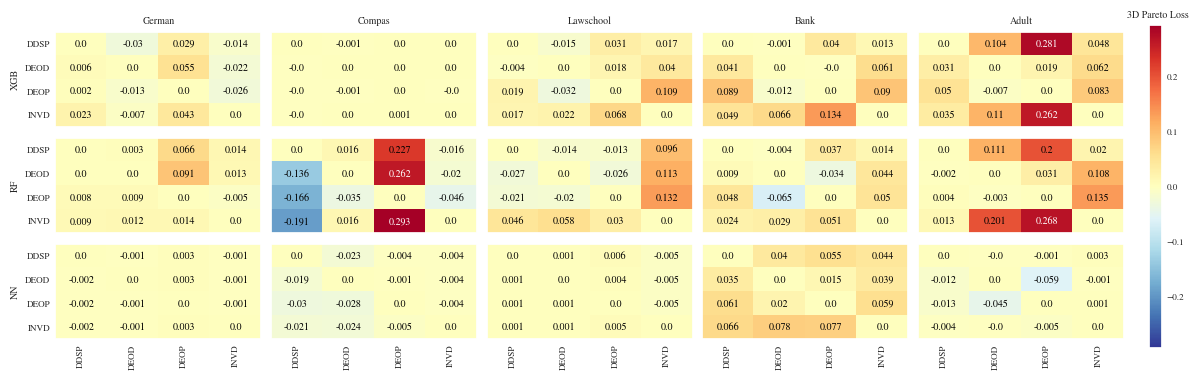

In [56]:
sns.set(font_scale=0.6)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=len(model_names), ncols=len(dataset_names), figsize=(2.5*len(dataset_names), 1.25*len(model_names)))

if len(model_names) == 1:
    axes = [axes]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette()

differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))
for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):

        many_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys+test_keys]

        difference = np.zeros((len(obj_names), len(obj_names)))

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names):
                    
                if obj_name1 == obj_name2:
                    difference[k1][k2] = 0
                    continue

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]

                obj_observations2 = mo_experiments[(obj_name2, model, dataset)]['function_values'][val_keys+test_keys]

                both_observations = pd.concat([obj_observations1, obj_observations2, many_observations])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values), np.max(both_observations[[f'val_{fair_key2}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values), np.min(both_observations[[f'val_{fair_key2}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(many_observations[['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}']].values)
                est_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                difference[k1][k2] = true_hvol - est_hvol

        differences[i][j] = difference    

for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names): 

        im = axes[i][j].imshow(differences[i][j], vmin=-np.nanmax(differences), vmax=np.nanmax(differences), cmap='RdYlBu_r', aspect='auto')

        for k1, obj_name2 in enumerate(obj_names):
            for k2, obj_name2 in enumerate(obj_names):
                text = axes[i][j].text(k2, k1, np.around(differences[i][j], decimals=3)[k1][k2],
                       ha="center", va="center", color='white' if np.abs(differences[i][j][k1][k2]) > 0.25 else 'black')
        
        if i == 0:
            axes[i][j].set_title(f"{dataset.capitalize()}")
        
        if i == len(model_names)-1:
            axes[i][j].set_xticks(range(len(obj_names)))
            axes[i][j].set_xticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names], rotation=90)
        else:
            axes[i][j].set_xticks([])            
        if j == 0:
            axes[i][j].set_yticks(range(len(obj_names)))
            axes[i][j].set_yticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names])
            axes[i][j].set_ylabel(model.upper())
        else:
            axes[i][j].set_yticks([])
        
        axes[i][j].tick_params(which='both', size=0)
        axes[i][j].grid(False)

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.86])
cbar = fig.colorbar(im, cbar_ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(which='both', size=0)
cbar.ax.set_title('  3D Pareto Loss')

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq1/3D_pareto_loss.png', dpi=600)

0 0
0 1
0 2
0 3


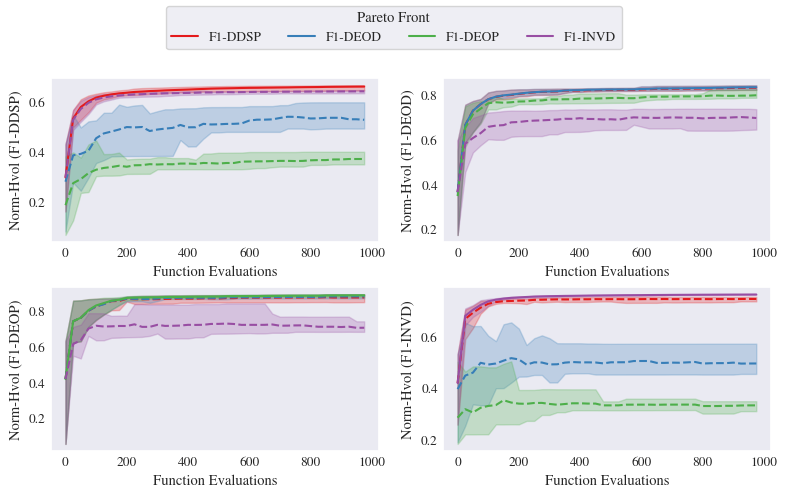

In [9]:
combs = [('rf', 'adult')]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*len(obj_names), 5*len(combs)))

colors = sns.color_palette('Set1')

ax_map = {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (1, 0), (0, 3): (1, 1)}

all_labels, all_handles = [], []
for i, (model, dataset) in enumerate(combs):
    for j, obj_name1 in enumerate(obj_names):
        fair_key1 = obj_name1.split('_')[1]

        all_observations = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys]

        eps = 0.00000001
        ndr = np.array([np.max(all_observations[['val_f1']].values), np.max(all_observations[[f'val_{fair_key1}']].values)]) + eps
        idl = np.array([np.min(all_observations[['val_f1']].values), np.min(all_observations[[f'val_{fair_key1}']].values)]) - eps
        norm_factor = hypervolume([idl]).compute(ndr)

        emp_hv = hypervolume(all_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

        for k, obj_name2 in enumerate(obj_names):
            fair_key2 = obj_name2.split('_')[1]

            hvol_convs = []
            for seed in range(10):
                observations = mo_experiments[(obj_name1, model, dataset)][str(seed)]['observations'][val_keys]
                hvol_conv = []
                for loc in range(0, len(set(observations.index))-2, 25):

                    curr_observations = observations.loc[np.arange(loc+2)]          

                    obj2_pareto = curr_observations[is_pareto_front(curr_observations[['val_f1', f'val_{fair_key2}']].values)]

                    log_hvol = hypervolume(obj2_pareto[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                    hvol_conv.append(log_hvol)
                
                hvol_convs.append(hvol_conv)

            df = pd.DataFrame(hvol_convs)
            df.fillna(method='ffill', axis=0, inplace=True)
            hvol_convs = df.values

            if fair_key1 != fair_key2:
                axes[ax_map[(i, j)]].plot(np.arange(40)*25, hvol_convs.mean(axis=0), color=colors[k], linestyle='dashed', alpha=1)
                axes[ax_map[(i, j)]].fill_between(np.arange(40)*25, hvol_convs.min(axis=0), hvol_convs.max(axis=0), color=colors[k], alpha=0.25)
            else:
                axes[ax_map[(i, j)]].plot(np.arange(40)*25, hvol_convs.mean(axis=0), color=colors[k], label=f'F1-{fair_key2.upper()}', alpha=1)
                axes[ax_map[(i, j)]].fill_between(np.arange(40)*25, hvol_convs.min(axis=0), hvol_convs.max(axis=0), color=colors[k], alpha=0.25)
        
        axes[ax_map[(i, j)]].tick_params(which='both', size=0)
        axes[ax_map[(i, j)]].grid(False)

        axes[ax_map[(i, j)]].set_xlabel('Function Evaluations')
        axes[ax_map[(i, j)]].set_ylabel(f'Norm-Hvol (F1-{fair_key1.upper()})')

        handles, labels = axes[ax_map[(i, j)]].get_legend_handles_labels()
        all_handles += handles
        all_labels += labels

        print(i, j)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=4, title='Pareto Front')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/hv_gap_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

0 0
0 1
0 2
0 3


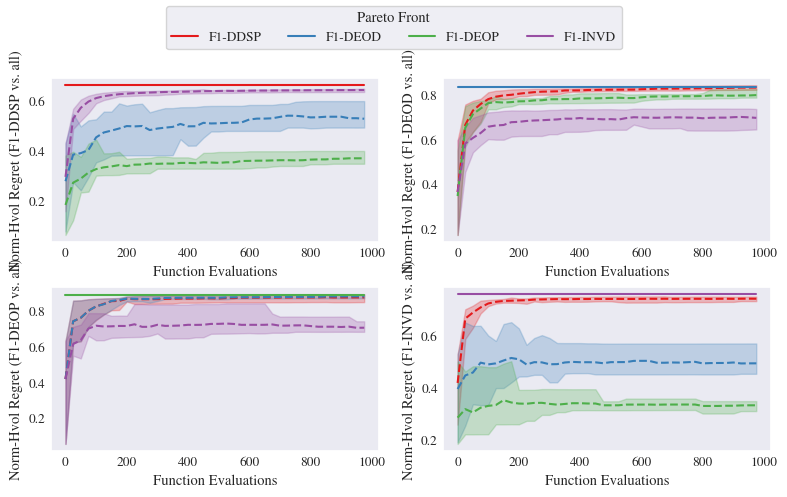

In [39]:
combs = [('rf', 'adult')]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*len(obj_names), 5*len(combs)))

colors = sns.color_palette('Set1')

ax_map = {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (1, 0), (0, 3): (1, 1)}

all_labels, all_handles = [], []
for i, (model, dataset) in enumerate(combs):
    for j, obj_name1 in enumerate(obj_names):
        fair_key1 = obj_name1.split('_')[1]

        all_observations = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys]

        eps = 0.00000001
        ndr = np.array([np.max(all_observations[['val_f1']].values), np.max(all_observations[[f'val_{fair_key1}']].values)]) + eps
        idl = np.array([np.min(all_observations[['val_f1']].values), np.min(all_observations[[f'val_{fair_key1}']].values)]) - eps
        norm_factor = hypervolume([idl]).compute(ndr)

        emp_hv = hypervolume(all_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

        for k, obj_name2 in enumerate(obj_names):
            fair_key2 = obj_name2.split('_')[1]

            hvol_convs, emp_convs = [], []
            for seed in range(10):
                obj_observations1 = mo_experiments[(obj_name1, model, dataset)][str(seed)]['observations'][val_keys]
                obj_observations2 = mo_experiments[(obj_name2, model, dataset)][str(seed)]['observations'][val_keys]

                hvol_conv = []
                for loc in range(0, len(set(observations.index))-2, 25):

                    curr_observations = observations.loc[np.arange(loc+2)]          

                    obj2_pareto = curr_observations[is_pareto_front(curr_observations[['val_f1', f'val_{fair_key2}']].values)]

                    log_hvol = hypervolume(obj2_pareto[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                    hvol_conv.append(log_hvol)
                
                hvol_convs.append(hvol_conv)

            df = pd.DataFrame(hvol_convs)
            df.fillna(method='ffill', axis=0, inplace=True)
            hvol_convs = df.values

            if fair_key1 != fair_key2:
                axes[ax_map[(i, j)]].plot(np.arange(40)*25, hvol_convs.mean(axis=0), color=colors[k], linestyle='dashed', alpha=1)
                axes[ax_map[(i, j)]].fill_between(np.arange(40)*25, hvol_convs.min(axis=0), hvol_convs.max(axis=0), color=colors[k], alpha=0.25)
            else:
                axes[ax_map[(i, j)]].plot(np.arange(40)*25, [hvol_convs.mean(axis=0)[-1]]*40, color=colors[k], label=f'F1-{fair_key2.upper()}', alpha=1)
                # axes[ax_map[(i, j)]].fill_between(np.arange(40)*25, hvol_convs.min(axis=0), hvol_convs.max(axis=0), color=colors[k], alpha=0.25)

            axes[ax_map[(i, j)]].plot(np.arange(40)*25, hvol_convs.mean(axis=0), color=colors[k], linestyle='dashed', alpha=1)
            axes[ax_map[(i, j)]].fill_between(np.arange(40)*25, hvol_convs.min(axis=0), hvol_convs.max(axis=0), color=colors[k], alpha=0.25)

        
        axes[ax_map[(i, j)]].tick_params(which='both', size=0)
        axes[ax_map[(i, j)]].grid(False)

        axes[ax_map[(i, j)]].set_xlabel('Function Evaluations')
        axes[ax_map[(i, j)]].set_ylabel(f'Norm-Hvol Regret (F1-{fair_key1.upper()} vs. all)')

        handles, labels = axes[ax_map[(i, j)]].get_legend_handles_labels()
        all_handles += handles
        all_labels += labels

        print(i, j)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=4, title='Pareto Front')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/hv_gap_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

0 0
0 1
0 2
0 3


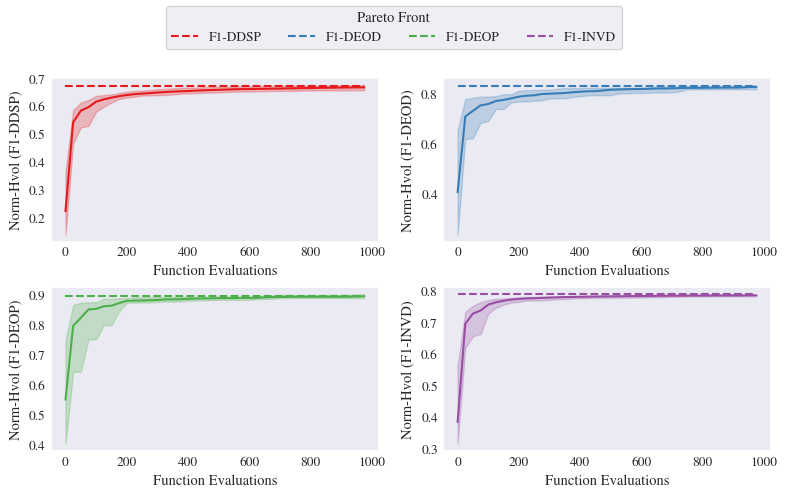

In [6]:
combs = [('rf', 'adult')]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*len(obj_names), 5*len(combs)))

colors = sns.color_palette('Set1')

ax_map = {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (1, 0), (0, 3): (1, 1)}

all_labels, all_handles = [], []

for i, (model, dataset) in enumerate(combs):
    for j, obj_name1 in enumerate(obj_names):
        fair_key1 = obj_name1.split('_')[1]

        multi_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys]
        obj1_observations = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys]

        all_observations = pd.concat([multi_observations, obj1_observations])

        eps = 0.00000001
        ndr = np.array([np.max(all_observations[['val_f1']].values), np.max(all_observations[[f'val_{fair_key1}']].values)]) + eps
        idl = np.array([np.min(all_observations[['val_f1']].values), np.min(all_observations[[f'val_{fair_key1}']].values)]) - eps
        norm_factor = hypervolume([idl]).compute(ndr)

        emp_hv = hypervolume(all_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

###########################

        hvol_convs, emp_hvs = [], []
        for seed in range(10):
            
            multi_observations = mo_experiments[('f1_multi', model, dataset)][str(seed)]['observations'][val_keys]  
            obj1_observations = mo_experiments[(obj_name1, model, dataset)][str(seed)]['observations'][val_keys]    

            hvol_conv = []
            step = 25
        
            for loc in range(0, len(set(multi_observations.index))-2, step):

                curr_observations = multi_observations.iloc[:loc+2]          

                obj2_pareto = curr_observations[is_pareto_front(curr_observations[val_keys].values)]

                log_hvol = hypervolume(obj2_pareto[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                hvol_conv.append(log_hvol)
            
            hvol_convs.append(hvol_conv)

            emp_hvs.append(hypervolume(obj1_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor)

        df = pd.DataFrame(hvol_convs)
        df.fillna(method='ffill', axis=0, inplace=True)
        hvol_convs = df.values

        axes[ax_map[(i, j)]].plot(np.arange(hvol_convs.mean(axis=0).size)*step, hvol_convs.mean(axis=0), linewidth=1.5, alpha=1, color=colors[j])
        axes[ax_map[(i, j)]].plot(np.arange(hvol_convs.mean(axis=0).size)*step, [np.mean(emp_hvs)]*hvol_convs.mean(axis=0).size, linewidth=1.5, alpha=1, linestyle='dashed', label=f'F1-{fair_key1.upper()}', color=colors[j])
        axes[ax_map[(i, j)]].fill_between(np.arange(hvol_convs.mean(axis=0).size)*step, hvol_convs.min(axis=0), hvol_convs.max(axis=0), alpha=0.25, color=colors[j])
        axes[ax_map[(i, j)]].grid(False)
        axes[ax_map[(i, j)]].tick_params(which='both', size=0)

        handles, labels = axes[ax_map[(i, j)]].get_legend_handles_labels()
        all_handles += handles
        all_labels += labels

        axes[ax_map[(i, j)]].tick_params(which='both', size=0)
        axes[ax_map[(i, j)]].grid(False)

        axes[ax_map[(i, j)]].set_xlabel('Function Evaluations')
        axes[ax_map[(i, j)]].set_ylabel(f'Norm-Hvol (F1-{fair_key1.upper()})')

        print(i, j)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=5, title='Pareto Front')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/hv_gap_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

0 0 0
0 0 1
0 0 2
0 0 3
0 1 0
0 1 1
0 1 2
0 1 3
0 2 0
0 2 1
0 2 2
0 2 3
0 3 0
0 3 1
0 3 2
0 3 3
0 4 0
0 4 1
0 4 2
0 4 3
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 1 3
1 2 0
1 2 1
1 2 2
1 2 3
1 3 0
1 3 1
1 3 2
1 3 3
1 4 0
1 4 1
1 4 2
1 4 3
2 0 0
2 0 1
2 0 2
2 0 3
2 1 0
2 1 1
2 1 2
2 1 3
2 2 0
2 2 1
2 2 2
2 2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 4 0
2 4 1
2 4 2
2 4 3


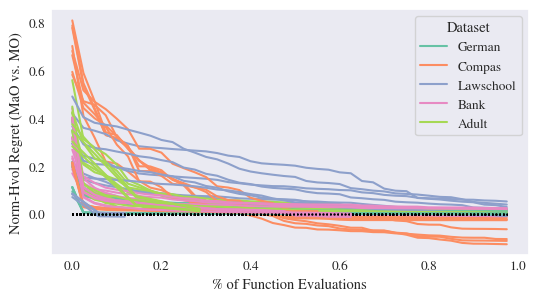

In [37]:

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

fig, ax = plt.subplots(figsize=(5.5, 3.5))

colors = sns.color_palette('Set2')

ax_map = {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (1, 0), (0, 3): (1, 1)}

all_labels, all_handles = [], []

results = {obj_name: {'wins': 0, 'losses': 0, 'ties': 0} for obj_name in obj_names}
for i, model in enumerate(model_names):
    for k, dataset in enumerate(dataset_names):
        for j, obj_name1 in enumerate(obj_names):
            fair_key1 = obj_name1.split('_')[1]

            multi_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys]
            obj1_observations = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys]

            all_observations = pd.concat([multi_observations, obj1_observations])

            eps = 0.00000001
            ndr = np.array([np.max(all_observations[['val_f1']].values), np.max(all_observations[[f'val_{fair_key1}']].values)]) + eps
            idl = np.array([np.min(all_observations[['val_f1']].values), np.min(all_observations[[f'val_{fair_key1}']].values)]) - eps
            norm_factor = hypervolume([idl]).compute(ndr)

    ###########################

            hvol_convs, emp_hvs = [], []
            for seed in range(10):
                
                multi_observations = mo_experiments[('f1_multi', model, dataset)][str(seed)]['observations'][val_keys]  
                obj1_observations = mo_experiments[(obj_name1, model, dataset)][str(seed)]['observations'][val_keys]    

                hvol_conv = []
                step = 25
            
                for loc in range(0, len(set(multi_observations.index))-2, step):

                    curr_observations = multi_observations.iloc[:loc+2]          

                    obj2_pareto = curr_observations[is_pareto_front(curr_observations[val_keys].values)]

                    log_hvol = hypervolume(obj2_pareto[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                    hvol_conv.append(log_hvol)
                
                hvol_convs.append(hvol_conv)

                emp_hvs.append(hypervolume(obj1_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor)

            df = pd.DataFrame(hvol_convs)
            df.fillna(method='ffill', axis=0, inplace=True)
            hvol_convs = df.values

            ax.plot(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, np.mean(emp_hvs) - hvol_convs.mean(axis=0), linewidth=1.5, alpha=1, label=dataset.capitalize(), color=colors[k])
            # ax.fill_between(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, np.mean(emp_hvs) - hvol_convs.max(axis=0), np.mean(emp_hvs) - hvol_convs.min(axis=0), alpha=0.25, color=colors[k])
            
            ax.plot(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, [0]*hvol_convs.mean(axis=0).size, linewidth=1, alpha=1, color='black', linestyle='dotted')
            # ax.fill_between(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, )
            
            # ax.plot(np.arange(hvol_convs.mean(axis=0).size)*step, [np.mean(emp_hvs)]*hvol_convs.mean(axis=0).size, linewidth=1.5, alpha=1, linestyle='dashed', label=f'F1-{fair_key1.upper()}', color=colors[j])
            # ax.fill_between(np.arange(hvol_convs.mean(axis=0).size)*step, hvol_convs.min(axis=0), hvol_convs.max(axis=0), alpha=0.25, color=colors[j])
            ax.grid(False)
            ax.tick_params(which='both', size=0)

            if hvol_convs.mean(axis=0)[-1] > np.mean(emp_hvs):
                results[obj_name1]['wins'] += 1
            elif hvol_convs.mean(axis=0)[-1] < np.mean(emp_hvs):
                results[obj_name1]['losses'] += 1
            else:
                results[obj_name1]['ties'] += 1

            handles, labels = ax.get_legend_handles_labels()
            all_handles += handles
            all_labels += labels

            ax.tick_params(which='both', size=0)
            ax.grid(False)

            ax.set_xlabel('% of Function Evaluations')
            ax.set_ylabel(f'Norm-Hvol Regret (MaO vs. MO)')

            print(i, k, j)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

by_label = dict(zip(all_labels, all_handles))
leg = ax.legend(by_label.values(), by_label.keys(), loc='upper right', title='Dataset', columnspacing=0.5)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/hv_regret.png', bbox_inches='tight', dpi=600)

In [ ]:

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

fig, ax = plt.subplots(figsize=(5.5, 3.5))

colors = sns.color_palette('Set2')

ax_map = {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (1, 0), (0, 3): (1, 1)}

all_labels, all_handles = [], []

results = {obj_name: {'wins': 0, 'losses': 0, 'ties': 0} for obj_name in obj_names}
for i, model in enumerate(model_names):
    for k, dataset in enumerate(dataset_names):
        for j, obj_name1 in enumerate(obj_names):
            fair_key1 = obj_name1.split('_')[1]

            multi_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys]
            obj1_observations = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys]

            all_observations = pd.concat([multi_observations, obj1_observations])

            eps = 0.00000001
            ndr = np.array([np.max(all_observations[['val_f1']].values), np.max(all_observations[[f'val_{fair_key1}']].values)]) + eps
            idl = np.array([np.min(all_observations[['val_f1']].values), np.min(all_observations[[f'val_{fair_key1}']].values)]) - eps
            norm_factor = hypervolume([idl]).compute(ndr)

            emp_hv = hypervolume(obj1_observations[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

    ###########################


            hvol_conv = []
            step = 200
        
            for loc in range(0, len(set(multi_observations.index))-2, step):

                curr_observations = multi_observations.iloc[:loc+2]          

                obj2_pareto = curr_observations[is_pareto_front(curr_observations[val_keys].values)]

                log_hvol = hypervolume(obj2_pareto[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                hvol_conv.append(log_hvol)
            
            hvol_convs.append(hvol_conv)

            df = pd.DataFrame(hvol_convs)
            df.fillna(method='ffill', axis=0, inplace=True)
            hvol_convs = df.values

            ax.plot(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, np.mean(emp_hvs) - hvol_convs.mean(axis=0), linewidth=1.5, alpha=1, label=dataset.capitalize(), color=colors[k])
            ax.plot(np.arange(hvol_convs.mean(axis=0).size)/hvol_convs.mean(axis=0).size, [0]*hvol_convs.mean(axis=0).size, linewidth=1.5, alpha=1, color='black', linestyle='dashed')
            
            # ax.plot(np.arange(hvol_convs.mean(axis=0).size)*step, [np.mean(emp_hvs)]*hvol_convs.mean(axis=0).size, linewidth=1.5, alpha=1, linestyle='dashed', label=f'F1-{fair_key1.upper()}', color=colors[j])
            # ax.fill_between(np.arange(hvol_convs.mean(axis=0).size)*step, hvol_convs.min(axis=0), hvol_convs.max(axis=0), alpha=0.25, color=colors[j])
            ax.grid(False)
            ax.tick_params(which='both', size=0)

            if hvol_convs.mean(axis=0)[-1] > np.mean(emp_hvs):
                results[obj_name1]['wins'] += 1
            elif hvol_convs.mean(axis=0)[-1] < np.mean(emp_hvs):
                results[obj_name1]['losses'] += 1
            else:
                results[obj_name1]['ties'] += 1

            handles, labels = ax.get_legend_handles_labels()
            all_handles += handles
            all_labels += labels

            ax.tick_params(which='both', size=0)
            ax.grid(False)

            ax.set_xlabel('% of Function Evaluations')
            ax.set_ylabel(f'Hypervolume Regret (MaO vs. MO)')

            print(i, k, j)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

by_label = dict(zip(all_labels, all_handles))
leg = ax.legend(by_label.values(), by_label.keys(), loc='upper right', title='Dataset', columnspacing=0.5)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/hv_regret_emp.png', bbox_inches='tight', dpi=600)

In [30]:
mo_experiments[('f1_ddsp', 'rf', 'lawschool')]['function_values']

,val_f1,val_ddsp,val_deod,val_deop,val_invd,test_f1,test_ddsp,test_deod,test_deop,test_invd
0,0.374511,0.499321,0.459602,0.486432,0.035398,0.373266,0.495994,0.457618,0.487647,0.035357
1,0.376755,0.494390,0.457056,0.486829,0.035176,0.375246,0.492806,0.456607,0.489156,0.035181
2,0.371578,0.506897,0.467396,0.494325,0.035823,0.369725,0.505367,0.464143,0.491066,0.035706
3,0.382198,0.479481,0.443116,0.471822,0.034796,0.381597,0.470984,0.436858,0.469619,0.034755
4,0.353708,0.549440,0.511168,0.543260,0.037901,0.353075,0.548001,0.512650,0.549476,0.037887
...,...,...,...,...,...,...,...,...,...,...
996,0.358428,0.524900,0.477776,0.483701,0.037681,0.357410,0.515409,0.460856,0.458207,0.037207
997,0.393446,0.408469,0.371338,0.381615,0.035373,0.390184,0.406175,0.373270,0.393485,0.035250
998,0.368375,0.501930,0.465518,0.498080,0.036042,0.366868,0.505393,0.462410,0.487071,0.036031
999,0.406312,0.376283,0.343869,0.361141,0.034112,0.408437,0.380369,0.346129,0.357166,0.034338


In [20]:
results

{'f1_ddsp': {'wins': 5, 'losses': 6, 'ties': 4},
 'f1_deod': {'wins': 4, 'losses': 7, 'ties': 4},
 'f1_deop': {'wins': 3, 'losses': 8, 'ties': 4},
 'f1_invd': {'wins': 3, 'losses': 8, 'ties': 4}}

In [31]:
# the probability that MaO is signficantly different than MO

binomtest(k=results['f1_ddsp']['wins'], n=15, p=0.5, alternative='two-sided')

BinomTestResult(k=5, n=15, alternative='two-sided', proportion_estimate=0.3333333333333333, pvalue=0.30175781249999994)

In [52]:
from scipy.stats import binomtest

binom_table = {obj_name: {'Wins/Ties/Losses': 0, 'p-value': 0} for obj_name in obj_names}

all_wins, all_losses = 0, 0
for obj_name in obj_names:
    binom_result = binomtest(k=results[obj_name]['wins'], n=results[obj_name]['wins'] + results[obj_name]['losses'], p=0.5, alternative='less')
    binom_table[obj_name]['Wins/Ties/Losses'] = f"{results[obj_name]['wins']}/{results[obj_name]['ties']}/{results[obj_name]['losses']}"
    binom_table[obj_name]['p-value'] = binom_result.pvalue

    all_wins += results[obj_name]['wins']
    all_losses += results[obj_name]['losses']

binom_result = binomtest(k=all_wins, n=all_wins+all_losses, p=0.5, alternative='less')

binom_table['F1-MULTI vs. All'] = {}
binom_table['F1-MULTI vs. All']['Wins/Ties/Losses'] = f"{all_wins}/{0}/{all_losses}"
binom_table['F1-MULTI vs. All']['p-value'] = binom_result.pvalue


binom_df = pd.DataFrame(binom_table).T

col_map = {obj_name: f"F1-MULTI vs. F1-{obj_name.split('_')[1].upper()}" for obj_name in obj_names}
binom_df = binom_df.rename(col_map)

with open('/work/dlclarge2/robertsj-fairmohpo/figures/rq2/binom_test.csv', 'w+') as f:
    binom_df.to_csv(f)

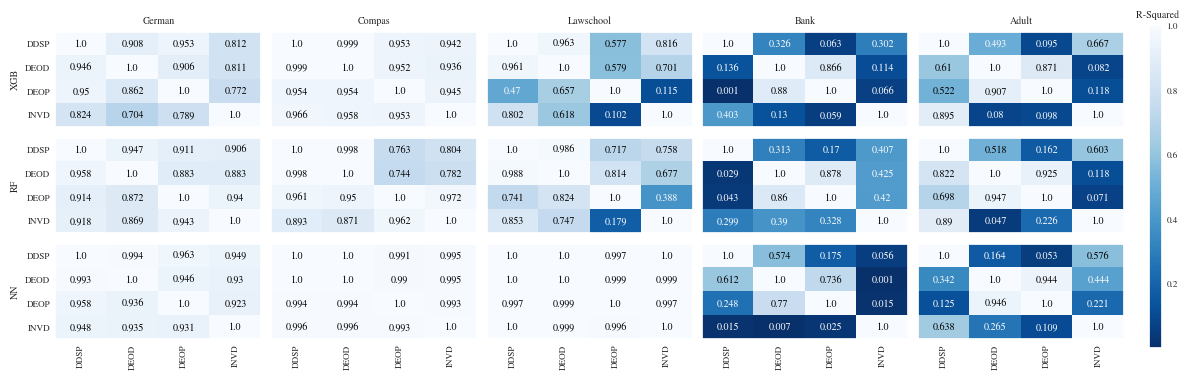

In [64]:
sns.set(font_scale=0.6)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=len(model_names), ncols=len(dataset_names), figsize=(2.5*len(dataset_names), 1.25*len(model_names)))

if len(model_names) == 1:
    axes = [axes]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette()

corrs, p_values = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names))), np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))
for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]
            obj_observations1 = obj_observations1[obj_observations1['val_f1'] < 0.5]
            pareto1_mask = is_pareto_front(obj_observations1[['val_f1', f'val_{fair_key1}']].values)
            obj1_pareto = obj_observations1[pareto1_mask]

            for k2, obj_name2 in enumerate(obj_names):
                    
                # if obj_name1 == obj_name2:
                #     difference[k1][k2] = np.nan
                #     continue

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]

                obj_observations2 = mo_experiments[(obj_name2, model, dataset)]['function_values'][val_keys+test_keys]
                obj_observations2 = obj_observations2[obj_observations2['val_f1'] < 0.5]
                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}']].values)
                obj2_pareto = obj_observations2[pareto2_mask]

                both_observations = pd.concat([obj_observations1])
        
                _, _, corrs[i][j][k1][k2], p_values[i][j][k1][k2], _ = linregress(both_observations[f'val_{fair_key1}'], both_observations[f'val_{fair_key2}'], )
                corrs[i][j][k1][k2] = corrs[i][j][k1][k2] ** 2

corrs, p_values = np.around(corrs, decimals=3), np.around(p_values, decimals=2)

for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names): 

        im = axes[i][j].imshow(corrs[i][j], vmin=np.min(corrs), vmax=1, cmap='Blues_r', aspect='auto')

        for k1, obj_name2 in enumerate(obj_names):
            for k2, obj_name2 in enumerate(obj_names):
                text = axes[i][j].text(k2, k1, f'{str(corrs[i][j][k1][k2])}',
                       ha="center", va="center", 
                       color='white' if corrs[i][j][k1][k2] < 0.5 else 'black'
                    )
        
        if i == 0:
            axes[i][j].set_title(f"{dataset.capitalize()}")
        
        if i == len(model_names)-1:
            axes[i][j].set_xticks(range(len(obj_names)))
            axes[i][j].set_xticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names], rotation=90)
        else:
            axes[i][j].set_xticks([])            
        if j == 0:
            axes[i][j].set_yticks(range(len(obj_names)))
            axes[i][j].set_yticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names])
            axes[i][j].set_ylabel(model.upper())
        else:
            axes[i][j].set_yticks([])
        
        axes[i][j].tick_params(which='both', size=0)
        axes[i][j].grid(False)

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.86])
cbar = fig.colorbar(im, cbar_ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(which='both', size=0)
cbar.ax.set_title('  R-Squared')

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq1/r_squared_error.png', dpi=300)

### Visualizing fairness metric conflicts

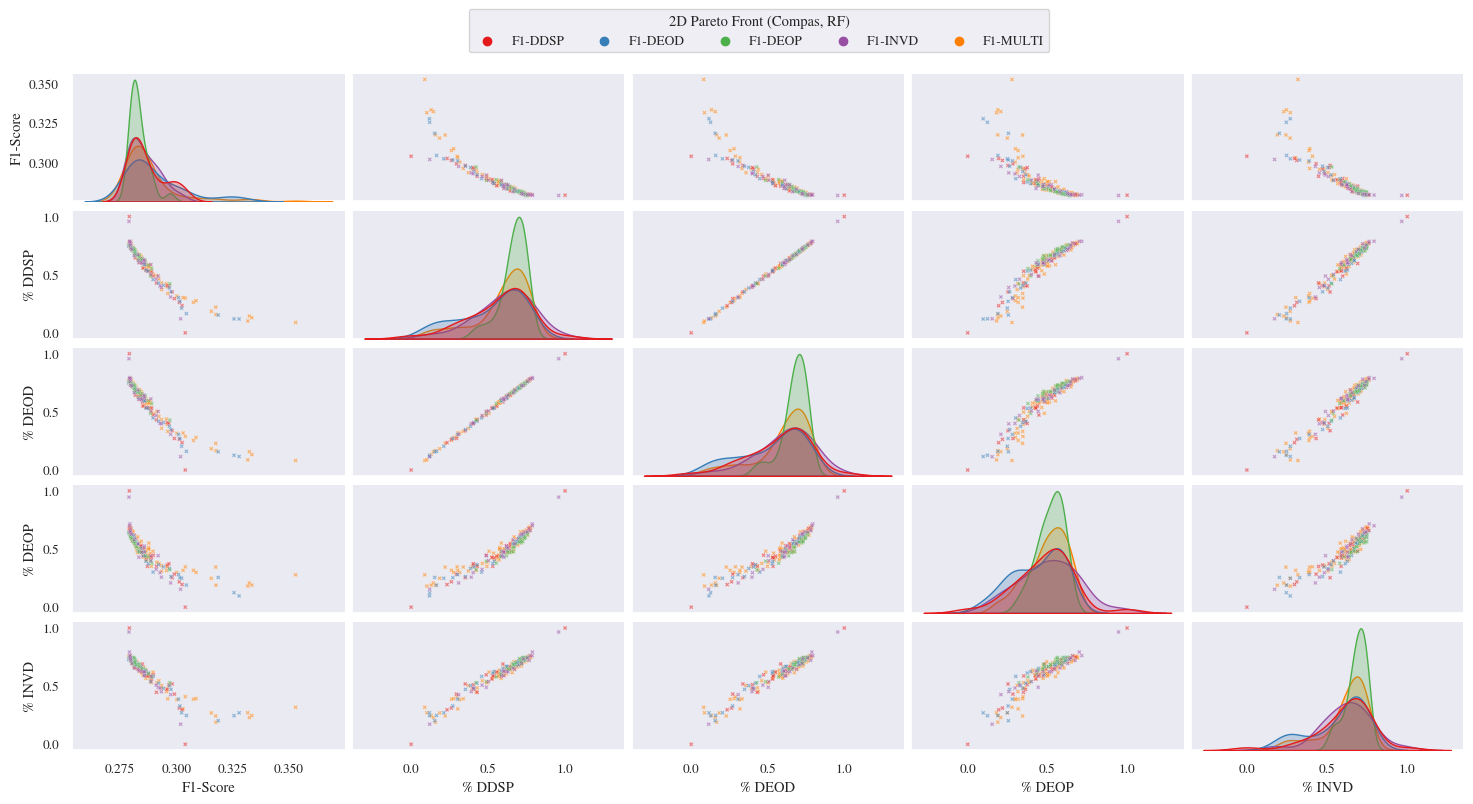

In [56]:
sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

model, dataset = 'rf', 'compas'

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)

observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys].reset_index()
observations['Pareto Front'] = f'F1-MULTI'
observations = observations[observations['val_f1'] < 0.75]
observations = observations[is_pareto_front(observations[val_keys].values)]
all_observations = pd.concat([all_observations, observations])

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    # observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] < 0.75]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    all_observations = pd.concat([all_observations, observations])

for obj_name in obj_names:
    fair_key = obj_name.split('_')[1]
    all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

many_observations = mo_experiments[('f1_comp', model, dataset)]['function_values'][val_keys].reset_index()

g = sns.pairplot(
    all_observations.reset_index(),
    vars=val_keys, kind='scatter',
    hue='Pareto Front', diag_kind='kde', markers='X', diag_kws=dict(common_norm=False), 
    palette='Set1', plot_kws=dict(alpha=0.5, s=10, edgecolors='white'), height=1.5, aspect=2,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD', 'F1-MULTI']
)

for i, ylabel in enumerate(val_keys):
    for j, xlabel in enumerate(val_keys):

        # if i != j:
        #     g.axes[i][j].scatter(many_observations[xlabel], many_observations[ylabel], marker='X', color='lightgrey', zorder=0, s=10, alpha=0.375)

        # if i != j:
        #     g.axes[i][j].plot([0, 1], [0, 1], zorder=2, linestyle='dashed', color='grey', label='X=Y')
        #     g.axes[i][j].text(1, 0, s='y < x', horizontalalignment='left')
        #     g.axes[i][j].text(0, 1, s='x < y', horizontalalignment='right', verticalalignment='top')


        g.axes[i][j].grid(False)
        if xlabel == 'val_f1':
            g.axes[i][j].set_xlabel(f"{xlabel.split('_')[1].upper()}-Score")
        else:
            g.axes[i][j].set_xlabel(f"% {xlabel.split('_')[1].upper()}")
        
        if ylabel == 'val_f1':
            g.axes[i][j].set_ylabel(f"{ylabel.split('_')[1].upper()}-Score")
        else:
            g.axes[i][j].set_ylabel(f"% {ylabel.split('_')[1].upper()}")

sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.48, 1.075), ncol=5, title=f'2D Pareto Front ({dataset.capitalize()}, {model.upper()})', frameon=True)

fig = plt.gcf()

# fig.subplots_adjust(bottom=0.2)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/conflict_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

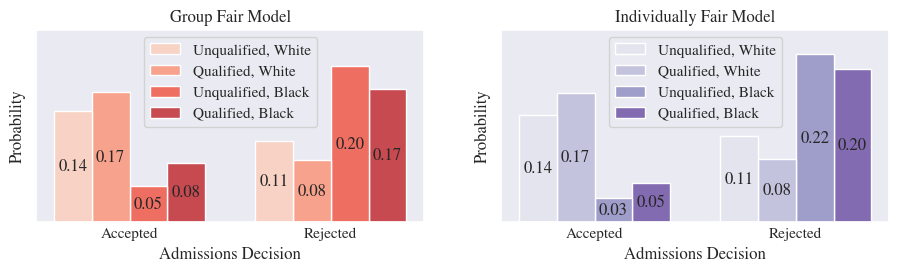

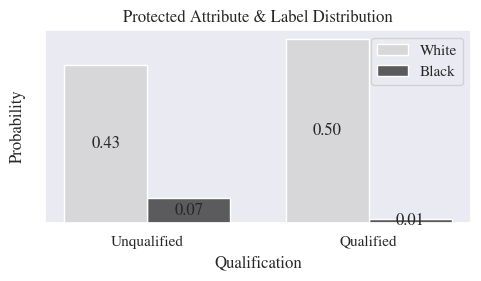

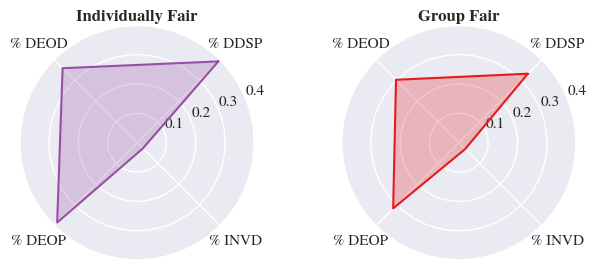

In [29]:
model, dataset = 'rf', 'lawschool'

cs = get_config_space(model, seed=1)
hparams = cs.get_hyperparameter_names()

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
all_archive = pd.DataFrame(columns=hparams)

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    archive = mo_experiments[(obj_name, model, dataset)]['archive']
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    archive['Pareto Front'] = f'F1-{fair_key.upper()}'
    # observations[f'val_{fair_key}'] = minmax_scale(observations[f'val_{fair_key}'])

    observations = observations[observations['val_f1'] < 0.75]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    archive = archive.iloc[observations.index]

    all_observations = pd.concat([all_observations, observations])
    all_archive = pd.concat([all_archive, archive])

# for obj_name in obj_names:
#     fair_key = obj_name.split('_')[1]
#     all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

all_archive['index'] = np.arange(all_archive.shape[0])
all_observations['index'] = np.arange(all_observations.shape[0])

invd_pareto = all_observations[all_observations['Pareto Front'] == 'F1-INVD']
group_pareto = all_observations[all_observations['Pareto Front'] == 'F1-DDSP']

max_f1_invd_pareto = invd_pareto.iloc[np.argmax(invd_pareto['val_f1'])]
sim_f1_group_pareto = group_pareto[group_pareto['val_f1'] <= max_f1_invd_pareto['val_f1']]
sim_f1_group_pareto = sim_f1_group_pareto.iloc[np.argmax(sim_f1_group_pareto['val_f1'])]

group_config = all_archive.iloc[sim_f1_group_pareto['index']]
invd_config = all_archive.iloc[max_f1_invd_pareto['index']]

X, y = get_dataset(dataset)

outer_kfold = StratifiedKFold(10)
prot_column = y.index.to_frame()['race'].values
outer_strat = get_strat(y.values, prot_column)

group_pred, invd_pred = np.empty(len(y)), np.empty(len(y))
for train_idx, test_idx in outer_kfold.split(X, outer_strat):

    invd_model = get_model(invd_config, 'rf', n_features=X.shape[1])
    group_model = get_model(group_config, 'rf', n_features=X.shape[1])

    invd_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    group_model.fit(X.iloc[train_idx], y.iloc[train_idx])

    invd_pred[test_idx] = invd_model.predict(X.iloc[test_idx])
    group_pred[test_idx] = group_model.predict(X.iloc[test_idx])

X['group_pred'], X['invd_pred'], X['y'] = group_pred, invd_pred, y.values
X = X.reset_index().astype('category')

X['group_pred'] = X['group_pred'].cat.rename_categories({1: 'Accepted', 0: 'Rejected'})
X['invd_pred'] = X['invd_pred'].cat.rename_categories({1: 'Accepted', 0: 'Rejected'})

X['y'] = X['y'].cat.rename_categories({1: 'Qualified', 0: 'Unqualified'})
X['race'] = X['race'].cat.rename_categories({1: 'White', 0: 'Black'})

sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(ncols=2, figsize=(11, 2.5))

sns.histplot(
    data=X, x=X['group_pred'].astype(str), 
    hue=X['y'].astype(str) + ', ' + X['race'].astype(str), palette='Reds',
    ax=axes[0], stat='probability', multiple='dodge', shrink=0.75, common_norm=False
)

sns.histplot(
    data=X, x=X['invd_pred'].astype(str),
    hue=X['y'].astype(str) + ', ' + X['race'].astype(str), palette='Purples',
    ax=axes[1], stat='probability', multiple='dodge', shrink=0.75, common_norm=False
)

for p in axes[0].patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h/4:0.2f}'
    axes[0].annotate(text=text, xy=xy, ha='center', va='center')

for p in axes[1].patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h/4:0.2f}'
    axes[1].annotate(text=text, xy=xy, ha='center', va='center')

axes[1].set_yticklabels([])
axes[0].set_yticklabels([])
axes[1].set_title('Individually Fair Model')
axes[0].set_title('Group Fair Model')

axes[1].tick_params(which='both', size=0)
axes[0].tick_params(which='both', size=0)

axes[1].grid(False)
axes[0].grid(False)

axes[0].set_ylim((0, 1))
axes[1].set_ylim((0, 1))

axes[0].set_xlabel('Admissions Decision')
axes[1].set_xlabel('Admissions Decision')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/conflict_pred_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

fig, ax = plt.subplots(figsize=(5.5, 2.5))

colors = np.array(sns.color_palette('Greys'))
sns.histplot(
    data=X, x=X['y'].astype(str), 
    hue=X['race'].astype(str).values, palette=colors[[1, 5]],
    ax=ax, stat='probability', multiple='dodge', shrink=0.75, common_norm=True
)

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

ax.set_yticklabels([])
ax.grid(False)
ax.set_title('Protected Attribute & Label Distribution')
ax.set_xlabel('Qualification')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/ground_truth_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

obj_space = pd.concat([max_f1_invd_pareto, sim_f1_group_pareto], axis=1).T
# obj_space['Pareto Front'] = ['Individually Fair Model', 'Group Fair Model']
obj_space = obj_space.drop(columns=['index', 'val_f1'])
obj_space = obj_space.rename(columns={'val_f1': 'F1-Score', 'val_ddsp': '% DDSP', 'val_deod': '% DEOD', 'val_deop': '% DEOP', 'val_invd': '% INVD'})

# melted_df = obj_space.melt(id_vars=['Pareto Front'], var_name='Category', value_name='Value')

# colors = np.array(sns.color_palette('crest'))
# sns.barplot(x='Category', y='Value', hue=melted_df['Pareto Front'].values, data=melted_df, ax=axes[0], alpha=0.85, palette=colors[[1, 5]])

# for p in axes[0].patches:
#     h, w, x = p.get_height(), p.get_width(), p.get_x()
#     xy = (x + w / 2., h / 2)
#     text = f'{h:0.2f}'
#     axes[0].annotate(text=text, xy=xy, ha='center', va='center')


# axes[0].grid(False)
# axes[0].set_xlabel('Fairness Metric')
# axes[0].set_ylim((0, 0.55))
# axes[0].set_ylabel('% Unfairness')
# axes[0].set_title('Fairness Metric Conflict')

fig, axes = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6.5, 2.5), ncols=2)

theta = np.array(radar_factory(4, frame='circle')) + np.pi/4

data = [list(obj_space.columns[:-1]), 
        ('Individually Fair', obj_space[obj_space['Pareto Front'] == 'F1-INVD'].drop(columns=['Pareto Front']).values),
        ('Group Fair', obj_space[obj_space['Pareto Front'] == 'F1-DDSP'].drop(columns=['Pareto Front']).values)
]
spoke_labels = data.pop(0)

colors = sns.color_palette('Set1')
colors = [colors[3], colors[0]]
# Plot the four cases from the example data on separate axes
for ax, (title, case_data), color in zip(axes, data, colors):
    # ax.set_rgrids([0.1, 0.2, 0.3, 0.4], angle=45, zorder=2)
    ax.tick_params(which='both', size=5)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(list(theta) + [theta[0]], list(d) + [d[0]], color=color)
        ax.fill(list(theta) + [theta[0]], list(d) + [d[0]], facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_xticks(theta)
    ax.set_xticklabels(spoke_labels)
    ax.set_ylim(0, 0.4)

fig.tight_layout(pad=0)
# add legend relative to top-left plot
labels = ['Individually Fair Model', 'Group Fair Model']

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/radar_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

['% DDSP', '% DEOD', '% DEOP', '% INVD']


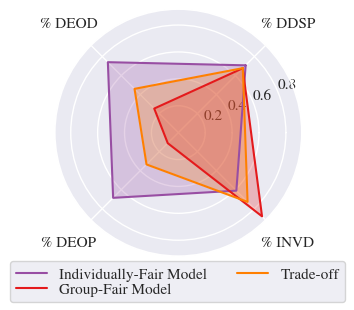

In [28]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

model, dataset = 'rf', 'adult'

cs = get_config_space(model, seed=1)
hparams = cs.get_hyperparameter_names()

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
all_archive = pd.DataFrame(columns=hparams)

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    archive = mo_experiments[(obj_name, model, dataset)]['archive']
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    archive['Pareto Front'] = f'F1-{fair_key.upper()}'
    # observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] > 0.4]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    archive = archive.iloc[observations.index]

    all_observations = pd.concat([all_observations, observations])
    all_archive = pd.concat([all_archive, archive])

multi_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys].reset_index()
multi_observations = multi_observations[multi_observations['val_f1'] < 0.9]
multi_pareto = multi_observations[is_pareto_front(multi_observations[val_keys].values)]
multi_pareto['Pareto Front'] = f'F1-MULTI'

all_observations = pd.concat([all_observations, multi_pareto])

for obj_name in obj_names:
    fair_key = obj_name.split('_')[1]
    all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

all_archive['index'] = np.arange(all_archive.shape[0])
all_observations['index'] = np.arange(all_observations.shape[0])

invd_pareto = all_observations[all_observations['Pareto Front'] == 'F1-INVD']
ddsp_pareto = all_observations[all_observations['Pareto Front'] == 'F1-DDSP']
multi_pareto = all_observations[all_observations['Pareto Front'] == 'F1-MULTI']

invd_pareto = invd_pareto.iloc[np.argmax(invd_pareto['val_invd'])]
ddsp_pareto = ddsp_pareto.iloc[np.argmax(ddsp_pareto['val_ddsp'])]
multi_pareto = multi_pareto[(np.round(multi_pareto['val_f1'], decimals=3) == np.round(invd_pareto['val_f1'], decimals=3))]
multi_pareto = multi_pareto.iloc[0]

obj_space = pd.concat([invd_pareto, ddsp_pareto, multi_pareto], axis=1).T
# obj_space['Pareto Front'] = ['Individually Fair Model', 'Group Fair Model']
obj_space = obj_space.drop(columns=['index'])
obj_space = obj_space.rename(columns={'val_f1': 'F1-Score', 'val_ddsp': '% DDSP', 'val_deod': '% DEOD', 'val_deop': '% DEOP', 'val_invd': '% INVD'})

### 

fig, axes = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(3.5, 3.5))

theta = np.array(radar_factory(4, frame='polygon')) + np.pi/4

data = [list(obj_space.columns[1:-1]), 
        ('', obj_space.drop(columns=['Pareto Front', 'F1-Score']).values),
]
spoke_labels = data.pop(0)

print(spoke_labels)

colors = sns.color_palette('Set1')
colors = [colors[3], colors[0], colors[4]]
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip([axes], data):
    # ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], angle=45, zorder=2)
    ax.tick_params(which='both', size=12)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(list(theta) + [theta[0]], list(d) + [d[0]], color=color)
        ax.fill(list(theta) + [theta[0]], list(d) + [d[0]], facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_xticks(theta)
    ax.set_xticklabels(spoke_labels)

# add legend relative to top-left plot

labels = ['Individually-Fair Model', 'Group-Fair Model', 'Trade-off']
legend = fig.legend(labels, loc='lower center', ncol=2,
                              labelspacing=0.1)

fig.tight_layout(pad=2.5)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/radar_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

[0.30392488938671997 0.02931430409727144 0.025709705928914996
 0.016599005684382825 0.017291297761586548] [0.92399784 2.1806349  3.43727196 4.69390902 5.95054609]
[0.2790653312688037 0.1913199845712077 0.16078925235291694
 0.10871094706005359 0.08893565717867653] [0.92399784 2.1806349  3.43727196 4.69390902 5.95054609]


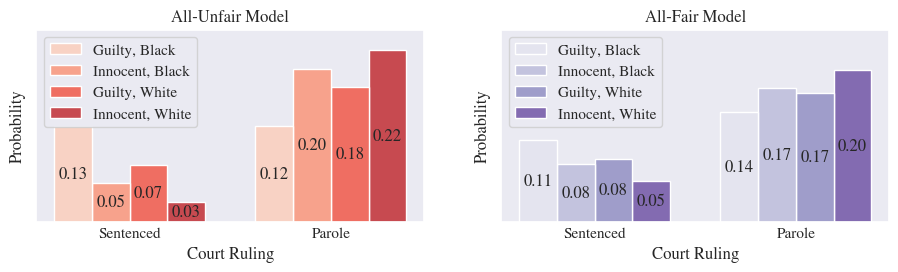

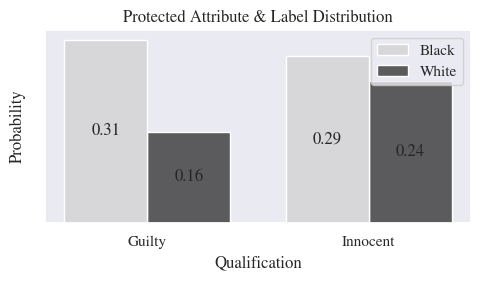

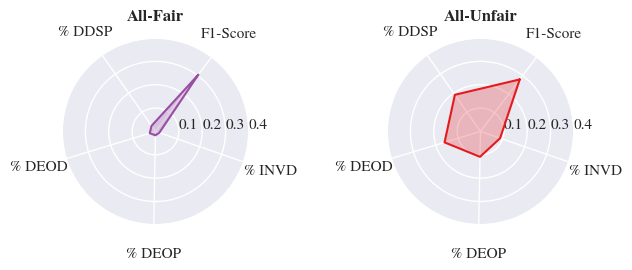

In [10]:
model, dataset = 'rf', 'compas'

cs = get_config_space(model, seed=1)
hparams = cs.get_hyperparameter_names()

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
all_archive = pd.DataFrame(columns=hparams)

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    archive = mo_experiments[(obj_name, model, dataset)]['archive']
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    archive['Pareto Front'] = f'F1-{fair_key.upper()}'
    # observations[f'val_{fair_key}'] = minmax_scale(observations[f'val_{fair_key}'])

    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    archive = archive.iloc[observations.index]

    all_observations = pd.concat([all_observations, observations])
    all_archive = pd.concat([all_archive, archive])

# for obj_name in obj_names:
#     fair_key = obj_name.split('_')[1]
#     all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

all_archive['index'] = np.arange(all_archive.shape[0])
all_observations['index'] = np.arange(all_observations.shape[0])

group_pareto = all_observations[all_observations['Pareto Front'] == 'F1-DDSP']

max_group_pareto = group_pareto.iloc[np.argmax(group_pareto['val_ddsp'])]
min_group_pareto = group_pareto.iloc[np.argmin(group_pareto['val_ddsp'])]


good_config = all_archive.iloc[min_group_pareto['index']]
bad_config = all_archive.iloc[max_group_pareto['index']]

orig_X, y = get_dataset(dataset)

encoder = get_encoder(orig_X)
X = pd.DataFrame(
    encoder.fit_transform(orig_X), index=orig_X.index, columns=orig_X.columns
)

proc_X = X.copy()

outer_kfold = StratifiedKFold(30)
prot_column = y.index.to_frame()['race'].values
outer_strat = get_strat(y.values, prot_column)

good_pred, bad_pred = np.empty(len(y)), np.empty(len(y))
good_imps, bad_imps = [], []
good_estimators, bad_estimators = [], []

idx = 0
for train_idx, test_idx in outer_kfold.split(X, outer_strat):

    good_model = get_model(good_config, 'rf', n_features=X.shape[1])
    bad_model = get_model(bad_config, 'rf', n_features=X.shape[1])

    good_estimators.append((str(idx), good_model))
    bad_estimators.append((str(idx), bad_model))

    good_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    bad_model.fit(X.iloc[train_idx], y.iloc[train_idx])

    good_pred[test_idx] = good_model.predict(X.iloc[test_idx])
    bad_pred[test_idx] = bad_model.predict(X.iloc[test_idx])

    idx += 1

X['bad_pred'], X['good_pred'], X['y'] = bad_pred, good_pred, y.values
X = X.reset_index().astype('category')

X['bad_pred'] = X['bad_pred'].cat.rename_categories({1: 'Parole', 0: 'Sentenced'})
X['good_pred'] = X['good_pred'].cat.rename_categories({1: 'Parole', 0: 'Sentenced'})

X['y'] = X['y'].cat.rename_categories({1: 'Innocent', 0: 'Guilty'})
X['race'] = X['race'].cat.rename_categories({1: 'White', 0: 'Black'})

sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(ncols=2, figsize=(11, 2.5))

sns.histplot(
    data=X, x=X['bad_pred'].astype(str), 
    hue=X['y'].astype(str) + ', ' + X['race'].astype(str), palette='Reds',
    ax=axes[0], stat='probability', multiple='dodge', shrink=0.75, common_norm=False
)

sns.histplot(
    data=X, x=X['good_pred'].astype(str),
    hue=X['y'].astype(str) + ', ' + X['race'].astype(str), palette='Purples',
    ax=axes[1], stat='probability', multiple='dodge', shrink=0.75, common_norm=False
)

for p in axes[0].patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h/4:0.2f}'
    axes[0].annotate(text=text, xy=xy, ha='center', va='center')

for p in axes[1].patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h/4:0.2f}'
    axes[1].annotate(text=text, xy=xy, ha='center', va='center')

axes[1].set_yticklabels([])
axes[0].set_yticklabels([])
axes[1].set_title('All-Fair Model')
axes[0].set_title('All-Unfair Model')

axes[1].tick_params(which='both', size=0)
axes[0].tick_params(which='both', size=0)

axes[1].grid(False)
axes[0].grid(False)

axes[0].set_ylim((0, 1))
axes[1].set_ylim((0, 1))

axes[0].set_xlabel('Court Ruling')
axes[1].set_xlabel('Court Ruling')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/conflict_pred_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

fig, ax = plt.subplots(figsize=(5.5, 2.5))

colors = np.array(sns.color_palette('Greys'))
sns.histplot(
    data=X, x=X['y'].astype(str), 
    hue=X['race'].astype(str).values, palette=colors[[1, 5]],
    ax=ax, stat='probability', multiple='dodge', shrink=0.75, common_norm=True
)

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

ax.set_yticklabels([])
ax.grid(False)
ax.set_title('Protected Attribute & Label Distribution')
ax.set_xlabel('Qualification')

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/ground_truth_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

obj_space = pd.concat([max_group_pareto, min_group_pareto], axis=1).T
# obj_space['Pareto Front'] = ['Individually Fair Model', 'Group Fair Model']
obj_space = obj_space.drop(columns=['index'])
obj_space = obj_space.rename(columns={'val_f1': 'F1-Score', 'val_ddsp': '% DDSP', 'val_deod': '% DEOD', 'val_deop': '% DEOP', 'val_invd': '% INVD'})

# melted_df = obj_space.melt(id_vars=['Pareto Front'], var_name='Category', value_name='Value')

# colors = np.array(sns.color_palette('crest'))
# sns.barplot(x='Category', y='Value', hue=melted_df['Pareto Front'].values, data=melted_df, ax=axes[0], alpha=0.85, palette=colors[[1, 5]])

# for p in axes[0].patches:
#     h, w, x = p.get_height(), p.get_width(), p.get_x()
#     xy = (x + w / 2., h / 2)
#     text = f'{h:0.2f}'
#     axes[0].annotate(text=text, xy=xy, ha='center', va='center')


# axes[0].grid(False)
# axes[0].set_xlabel('Fairness Metric')
# axes[0].set_ylim((0, 0.55))
# axes[0].set_ylabel('% Unfairness')
# axes[0].set_title('Fairness Metric Conflict')

fig, axes = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6.5, 2.5), ncols=2)

theta = np.array(radar_factory(5, frame='circle')) + np.pi/3.4

data = [list(obj_space.columns[:-1]), 
        ('All-Fair', obj_space.drop(columns=['Pareto Front']).iloc[1].values),
        ('All-Unfair', obj_space.drop(columns=['Pareto Front']).iloc[0].values)
]
spoke_labels = data.pop(0)

colors = sns.color_palette('Set1')
colors = [colors[3], colors[0]]
# Plot the four cases from the example data on separate axes
for ax, (title, case_data), color in zip(axes, data, colors):
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4], angle=0, zorder=2)
    ax.tick_params(which='both', size=10)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    
    print(case_data, theta)

    ax.plot(list(theta) + [theta[0]], list(case_data) + [case_data[0]], color=color)
    ax.fill(list(theta) + [theta[0]], list(case_data) + [case_data[0]], facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_xticks(theta)
    ax.set_xticklabels(spoke_labels)
    ax.set_ylim(0, 0.4)

fig.tight_layout(pad=0)
# add legend relative to top-left plot
labels = ['Individually Fair Model', 'Group Fair Model']

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/radar_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

In [11]:
from sklearn.ensemble import VotingClassifier
good_models = VotingClassifier(good_estimators, voting='soft')
good_models.fit(proc_X.values, y.values)

VotingClassifier(estimators=[('0',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_estimators=1)),
                             ('1',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_estimators=1)),
                             ('2',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_...
                             ('27',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_estimators=1)),
                             ('28',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_estimators=1)),
                             ('29',
                              RandomForestClassifier(max_depth=1,
                                                     max_features=1,
                                                     min_samples_leaf=4,
                                                     min_samples_split=24,
                                                     n_estimators=1))],
                 voting='soft')

In [12]:
good_imp = permutation_importance(good_models, proc_X, y, n_repeats=30, random_state=0).importances_mean
# bad_imp = permutation_importance(bad_models, proc_X, y, n_repeats=10, random_state=0).importances_mean

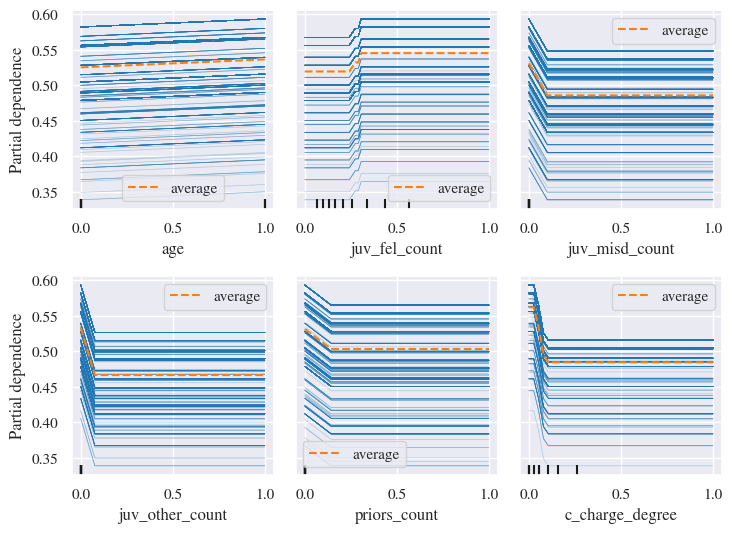

In [28]:
from sklearn.inspection import PartialDependenceDisplay

import itertools

fig, axes = plt.subplots(figsize=(7.5, 5.5), ncols=3, nrows=2)

PartialDependenceDisplay.from_estimator(good_models, proc_X, proc_X.columns, response_method='predict_proba', ax=axes, kind='both')

fig.tight_layout()
fig.show()

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/pdp_1d_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

# PartialDependenceDisplay.from_estimator(bad_models, proc_X, proc_X.columns, response_method='predict_proba', verbose=True)

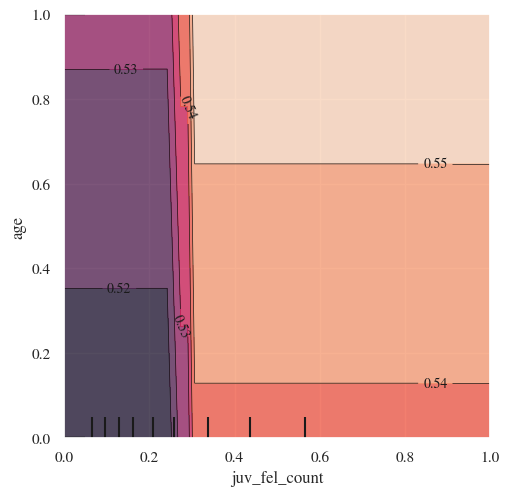

In [30]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))

PartialDependenceDisplay.from_estimator(good_models, proc_X, [('juv_fel_count', 'age')], response_method='predict_proba', ax=ax)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/pdp_2d_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

<AxesSubplot:xlabel='juv_fel_count', ylabel='c_charge_degree'>

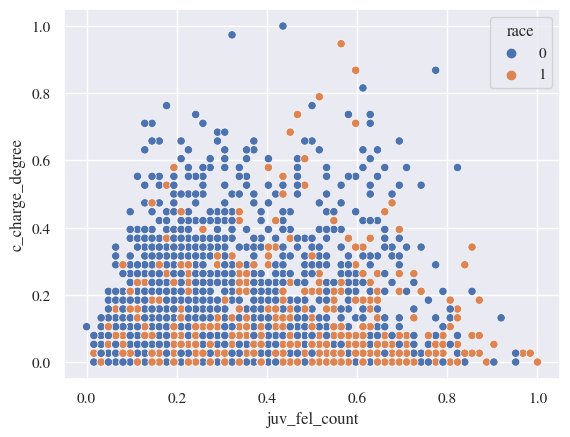

In [41]:
proc_X[(orig_X['age'] > 0.6) & (proc_X['juv_fel_count'] > 0.3)]

sns.scatterplot(data=proc_X, y='c_charge_degree', x='juv_fel_count', hue=orig_X.index.to_frame()['race'])

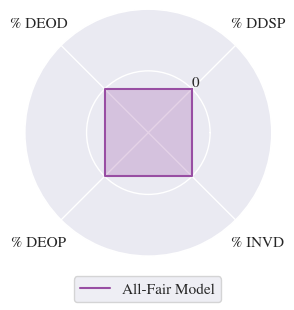

In [30]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

model, dataset = 'rf', 'compas'

cs = get_config_space(model, seed=1)
hparams = cs.get_hyperparameter_names()

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
all_archive = pd.DataFrame(columns=hparams)

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    archive = mo_experiments[(obj_name, model, dataset)]['archive']
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    archive['Pareto Front'] = f'F1-{fair_key.upper()}'
    # observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    archive = archive.iloc[observations.index]

    all_observations = pd.concat([all_observations, observations])
    all_archive = pd.concat([all_archive, archive])

multi_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys].reset_index()
multi_pareto = multi_observations[is_pareto_front(multi_observations[val_keys].values)]
multi_pareto['Pareto Front'] = f'F1-MULTI'

all_observations = pd.concat([all_observations, multi_pareto])

for obj_name in obj_names:
    fair_key = obj_name.split('_')[1]
    all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

all_archive['index'] = np.arange(all_archive.shape[0])
all_observations['index'] = np.arange(all_observations.shape[0])

ddsp_pareto = all_observations[all_observations['Pareto Front'] == 'F1-DDSP']
ddsp_pareto = ddsp_pareto.iloc[np.argmin(ddsp_pareto['val_ddsp'])]

obj_space = pd.concat([ddsp_pareto], axis=1).T
# obj_space['Pareto Front'] = ['Individually Fair Model', 'Group Fair Model']
obj_space = obj_space.drop(columns=['index'])
obj_space = obj_space.rename(columns={'val_f1': 'F1-Score', 'val_ddsp': '% DDSP', 'val_deod': '% DEOD', 'val_deop': '% DEOP', 'val_invd': '% INVD'})

### 

fig, axes = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(3.5, 3.5))

theta = np.array(radar_factory(4, frame='polygon')) + np.pi/4

data = [list(obj_space.columns[1:-1]), 
        ('', obj_space.drop(columns=['Pareto Front', 'F1-Score']).values),
]
spoke_labels = data.pop(0)

colors = sns.color_palette('Set1')
colors = [colors[3], colors[0], colors[4]]
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip([axes], data):
    ax.set_rgrids([0], angle=45, zorder=2)
    ax.tick_params(which='both', size=12)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(list(theta) + [theta[0]], list(d) + [d[0]], color=color)
        ax.fill(list(theta) + [theta[0]], list(d) + [d[0]], facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_xticks(theta)
    ax.set_xticklabels(spoke_labels)

# add legend relative to top-left plot

labels = ['All-Fair Model']
legend = fig.legend(labels, loc='lower center', ncol=2,
                              labelspacing=0.1)

fig.tight_layout(pad=2.5)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/radar_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

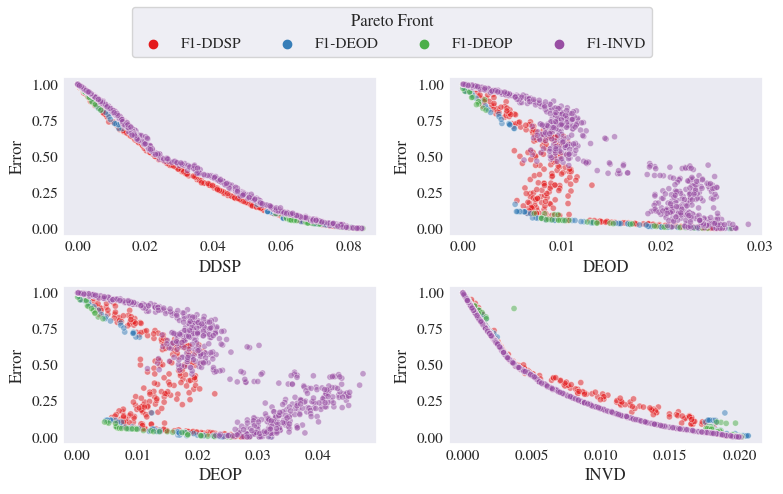

In [43]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(figsize=(8, 5), ncols=2, nrows=2)

model, dataset = 'rf', 'adult'

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette('Set1')

all_observations = pd.DataFrame(columns=val_keys)

# observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys].reset_index()
# observations['Pareto Front'] = f'F1-MULTI'
# observations = observations[observations['val_f1'] < 1]
# observations['val_f1'] = minmax_scale(observations['val_f1'])
# observations = observations[is_pareto_front(observations[val_keys].values)]
# all_observations = pd.concat([all_observations, observations])

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] < 1]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    all_observations = pd.concat([all_observations, observations])

# for obj_name in obj_names:
#     fair_key = obj_name.split('_')[1]
#     all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

many_observations = mo_experiments[('f1_comp', model, dataset)]['function_values'][val_keys].reset_index()

g = sns.scatterplot(
    data=all_observations,
    hue='Pareto Front', x='val_ddsp', y='val_f1',
    palette='Set1', s=20, alpha=0.5, edgecolor='white', linewidth=0.5,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD'], ax=axes[0][0], legend=False
)
axes[0][0].set_xlabel('DDSP')

g = sns.scatterplot(
    data=all_observations,
    hue='Pareto Front', x='val_deod', y='val_f1',
    palette='Set1', s=20, alpha=0.5, edgecolor='white', linewidth=0.5,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD'], ax=axes[0][1], legend=False
)
axes[0][1].set_xlabel('DEOD')

g = sns.scatterplot(
    data=all_observations,
    hue='Pareto Front', x='val_deop', y='val_f1',
    palette='Set1', s=20, alpha=0.5, edgecolor='white', linewidth=0.5,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD'], ax=axes[1][0], legend=False
)
axes[1][0].set_xlabel('DEOP')

g = sns.scatterplot(
    data=all_observations,
    hue='Pareto Front', x='val_invd', y='val_f1',
    palette='Set1', s=20, alpha=0.5, edgecolor='white', linewidth=0.5,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD'], ax=axes[1][1]
)
axes[1][1].set_xlabel('INVD')

handles, labels = axes[1][1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=4, title='Pareto Front')
axes[1][1].legend().remove()

for i in range(2):
    for j in range(2):
        axes[i][j].set_ylabel('Error')
        axes[i][j].grid(False)
        axes[i][j].tick_params(which='both', size=0)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq1/multi_pareto_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

# [RQ2] Optimizing for Multiple Notions of Fairness

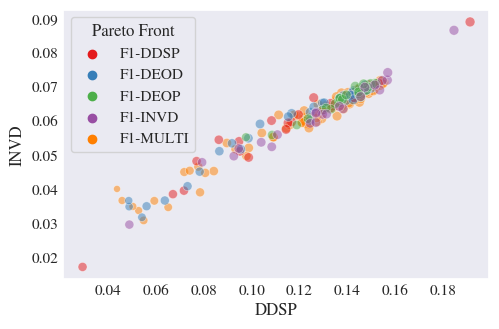

In [3]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, ax = plt.subplots(figsize=(5.5, 3.5))

model, dataset = 'rf', 'compas'

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette('Set1')

all_observations = pd.DataFrame(columns=val_keys)

observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys].reset_index()
observations['Pareto Front'] = f'F1-MULTI'
observations = observations[observations['val_f1'] < 1]
observations['val_f1'] = minmax_scale(observations['val_f1'])
observations = observations[is_pareto_front(observations[val_keys].values)]
all_observations = pd.concat([all_observations, observations])

for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] < 1]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    all_observations = pd.concat([all_observations, observations])

# for obj_name in obj_names:
#     fair_key = obj_name.split('_')[1]
#     all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

many_observations = mo_experiments[('f1_comp', model, dataset)]['function_values'][val_keys].reset_index()

g = sns.scatterplot(
    data=all_observations,
    hue='Pareto Front', x='val_ddsp', y='val_invd',
    palette='Set1', ax=ax, s=(1-all_observations['val_f1'].values)*50, alpha=0.5, edgecolor='white', linewidth=0.5,
    hue_order= ['F1-DDSP', 'F1-DEOD', 'F1-DEOP', 'F1-INVD', 'F1-MULTI']
)

for i in range(2):
    ax.set_xlabel('DDSP')
    ax.set_ylabel('INVD')
    ax.grid(False)
    ax.tick_params(which='both', size=0)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/multi_pareto_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

### 2D Pareto Front recovery

### Fairness metric conflict resolution

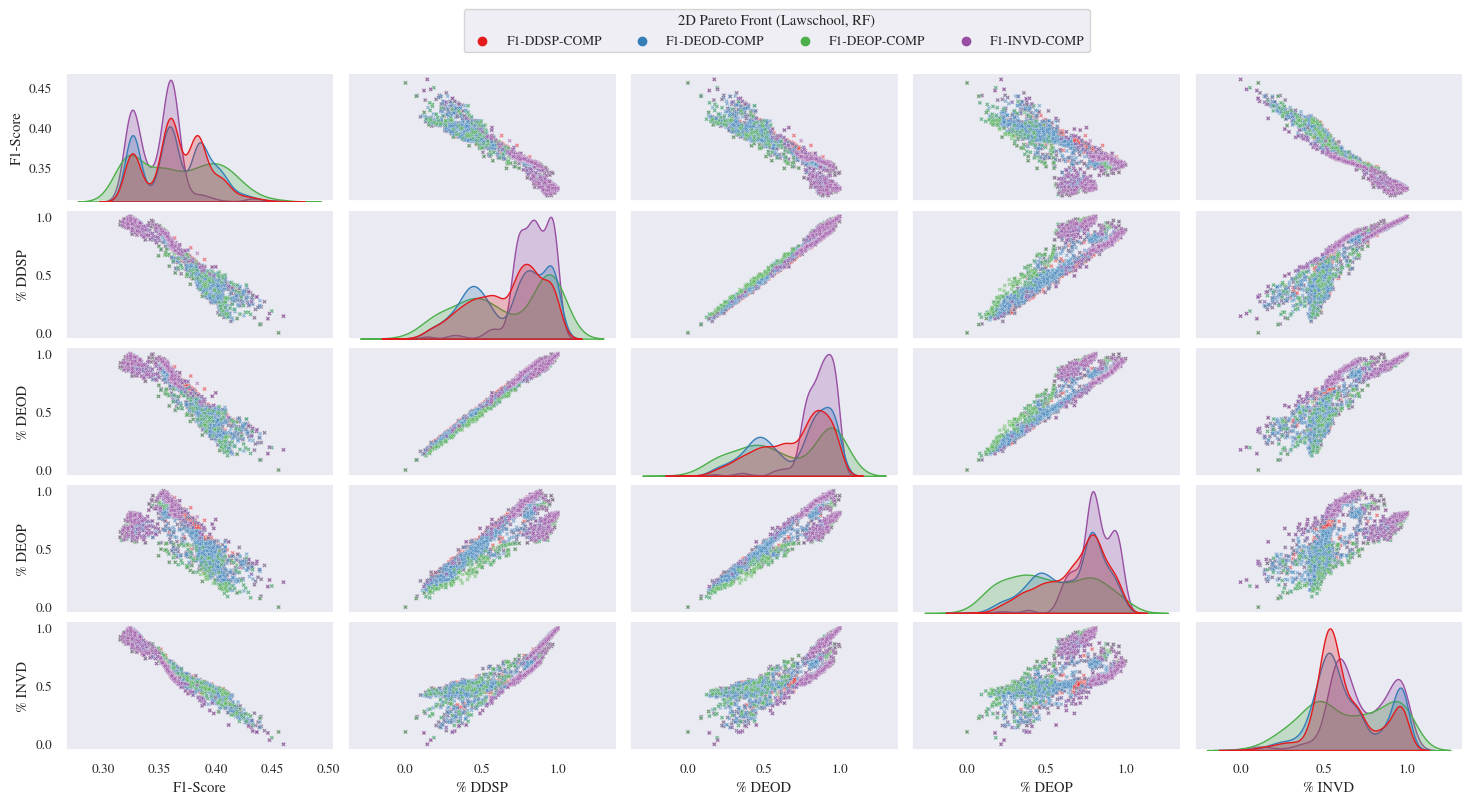

In [3]:
sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

model, dataset = 'rf', 'lawschool'

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
for obj_name in obj_names:
    
    # fair_key = obj_name.split('_')[1]
    # observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    # observations['Pareto Front'] = f'F1-{fair_key.upper()} (Bi)'
    # # observations['val_f1'] = minmax_scale(observations['val_f1'])
    # observations = observations[observations['val_f1'] < 0.5]
    # observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    # all_observations = pd.concat([all_observations, observations])

    fair_key = obj_name.split('_')[1]
    observations = many_experiments[('f1_comp', model, dataset)]['function_values'][val_keys+['val_comp']].reset_index()
    observations['Pareto Front'] = f'F1-{fair_key.upper()}-COMP'
    # observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] < 0.5]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}', 'val_comp']].values)]

    all_observations = pd.concat([all_observations, observations])

for obj_name in obj_names:
    fair_key = obj_name.split('_')[1]
    all_observations[f'val_{fair_key}'] = minmax_scale(all_observations[f'val_{fair_key}'])

g = sns.pairplot(
    all_observations.reset_index(),
    vars=val_keys, kind='scatter',
    hue='Pareto Front', diag_kind='kde', markers='X', diag_kws=dict(common_norm=False), 
    palette='Set1', plot_kws=dict(alpha=0.5, s=10), height=1.5, aspect=2
)

for i, ylabel in enumerate(val_keys):
    for j, xlabel in enumerate(val_keys):

        # if i != j:
        #     g.axes[i][j].plot([0, 1], [0, 1], zorder=2, linestyle='dashed', color='grey', label='X=Y')
        #     g.axes[i][j].text(1, 0, s='y < x', horizontalalignment='left')
        #     g.axes[i][j].text(0, 1, s='x < y', horizontalalignment='right', verticalalignment='top')

        g.axes[i][j].grid(False)
        if xlabel == 'val_f1':
            g.axes[i][j].set_xlabel(f"{xlabel.split('_')[1].upper()}-Score")
        else:
            g.axes[i][j].set_xlabel(f"% {xlabel.split('_')[1].upper()}")
        
        if ylabel == 'val_f1':
            g.axes[i][j].set_ylabel(f"{ylabel.split('_')[1].upper()}-Score")
        else:
            g.axes[i][j].set_ylabel(f"% {ylabel.split('_')[1].upper()}")

sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.48, 1.075), ncol=4, title=f'2D Pareto Front ({dataset.capitalize()}, {model.upper()})', frameon=True)

fig = plt.gcf()

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/conflict_resolution_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

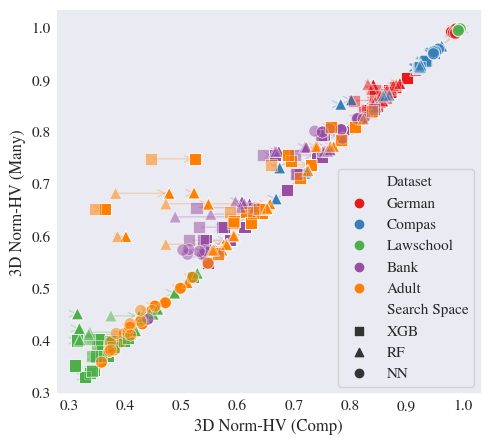

In [31]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, ax = plt.subplots(figsize=(5.5, 5))

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette(palette='Set1')
markers = ['s', '^', 'o', 'd']

count = 0
differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))

c = 0

res_df = pd.DataFrame(columns=['est_hv', 'true_hv', 'comp_hv', 'Search Space', 'Dataset', 'conflict'])

val_hvols, many_hvols = [], []
for j, dataset in enumerate(dataset_names):
    for i, model in enumerate(model_names):
        
        difference = np.zeros((len(obj_names), len(obj_names)))

        many_observations = many_experiments[('f1_comp', model, dataset)]['function_values'][val_keys+test_keys+['val_comp']]

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names): 

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]
                obj_observations2 = many_experiments[('f1_comp', model, dataset)]['function_values'][val_keys+test_keys+['val_comp']]

                both_observations = pd.concat([obj_observations1, obj_observations2, many_observations])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values), np.max(both_observations[[f'val_{fair_key2}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values), np.min(both_observations[[f'val_{fair_key2}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(many_observations[['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                paretocomp_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}', 'val_comp']].values)
                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}']].values)

                est_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor
                comp_hvol = hypervolume(obj_observations2[paretocomp_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor


                res_df = res_df.append({'est_hv': est_hvol, 'true_hv': true_hvol, 'comp_hv': comp_hvol, 'Search Space': model.upper(), 'Dataset': dataset.capitalize(), 'conflict': f'{fair_key1}-{fair_key2}'}, ignore_index=True)

                ax.annotate(
                    "", xy=(comp_hvol, true_hvol),
                    xytext=(est_hvol, true_hvol), label='fixme',
                    arrowprops=dict(arrowstyle= '->',
                                    linestyle='solid',
                                    alpha=0.25,
                                    color=colors[j]),
                    zorder=0                
                )

                    
sns.scatterplot(
    data=res_df, x='comp_hv', y='true_hv', 
    hue='Dataset', style='Search Space', markers=['s', '^', 'o'], s=75, ax=ax,
    palette='Set1'
)
sns.scatterplot(
    data=res_df, x='est_hv', y='true_hv',
    markers=['s', '^', 'o'], s=75, hue='Dataset', style='Search Space', alpha=0.5, ax=ax,
    palette='Set1'
)

ax.plot([0.35, 1], [0.35, 1], zorder=-1, color='lightgrey', linestyle='dashed')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=1)

ax.set_ylabel('3D Norm-HV (Many)')
ax.set_xlabel('3D Norm-HV (Comp)')
ax.tick_params(which='both', size=0)
ax.grid(False)

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq2/conflict_resolution.png', dpi=600, bbox_inches='tight',)

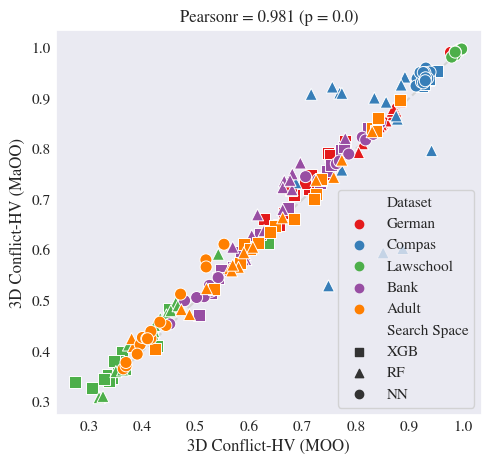

In [17]:
sns.set(font_scale=1)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(figsize=(11, 5), ncols=2)

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette(palette='Set1')
markers = ['s', '^', 'o', 'd']

count = 0
differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))

c = 0

res_df = pd.DataFrame(columns=['est_hv', 'true_hv', 'comp_hv', 'Search Space', 'Dataset', 'conflict'])

val_hvols, many_hvols = [], []
for j, dataset in enumerate(dataset_names):
    for i, model in enumerate(model_names):
        
        difference = np.zeros((len(obj_names), len(obj_names)))

        many_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys+test_keys]

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names): 

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]
                obj_observations2 = mo_experiments[(obj_name2, model, dataset)]['function_values'][val_keys+test_keys]

                both_observations = pd.concat([obj_observations1, obj_observations2, many_observations])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values), np.max(both_observations[[f'val_{fair_key2}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values), np.min(both_observations[[f'val_{fair_key2}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(many_observations[['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                paretomany_mask = is_pareto_front(many_observations[['val_f1', f'val_{fair_key2}']].values)
                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}']].values)

                true_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor
                est_hvol = hypervolume(many_observations[paretomany_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                res_df = res_df.append({'est_hv': est_hvol, 'true_hv': true_hvol, 'Search Space': model.upper(), 'Dataset': dataset.capitalize(), 'conflict': f'{fair_key1}-{fair_key2}'}, ignore_index=True)


sns.scatterplot(
    data=res_df, x='est_hv', y='true_hv', 
    hue='Dataset', style='Search Space', markers=['s', '^', 'o'], s=75, ax=axes[0],
    palette='Set1'
)

sns.scatterplot(
    data=res_df, x='est_hv', y='true_hv', 
    hue='Dataset', style='Search Space', markers=['s', '^', 'o'], s=75, ax=axes[1],
    palette='Set1'
)

corr, p = pearsonr(res_df['est_hv'], res_df['true_hv'])

ax.set_title(f'Pearsonr = {np.round(corr, decimals=3)} (p = {np.round(p, decimals=2)})')
ax.plot([0.35, 1], [0.35, 1], zorder=-1, color='lightgrey', linestyle='dashed')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=1)

ax.set_ylabel('Conflict Term (MaOO)')
ax.set_xlabel('Conflict Term (MOO)')
ax.tick_params(which='both', size=0)
ax.grid(False)

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq2/pareto_recovery.png', dpi=600, bbox_inches='tight',)

In [17]:
sns.set(font_scale=0.875)
sns.set_style({'font.family': 'STIXGeneral'})

model, dataset = 'xgb', 'lawschool'

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

all_observations = pd.DataFrame(columns=val_keys)
for obj_name in obj_names:
    
    fair_key = obj_name.split('_')[1]
    observations = mo_experiments[(obj_name, model, dataset)]['function_values'][val_keys].reset_index()
    observations['Pareto Front'] = f'F1-{fair_key.upper()}'
    observations['val_f1'] = minmax_scale(observations['val_f1'])
    observations = observations[observations['val_f1'] < 0.5]
    observations = observations[is_pareto_front(observations[['val_f1', f'val_{fair_key}']].values)]

    all_observations = pd.concat([all_observations, observations])

g = sns.pairplot(
    all_observations.reset_index(),
    vars=val_keys, kind='scatter',
    hue='Pareto Front', diag_kind='kde', markers='X', diag_kws=dict(common_norm=False), 
    palette='Set1', plot_kws=dict(alpha=0.5, s=10), height=1.5, aspect=2
)

for i, ylabel in enumerate(val_keys):
    for j, xlabel in enumerate(val_keys):

        # if i != j:
        #     g.axes[i][j].scatter(many_observations[xlabel], many_observations[ylabel], marker='X', color='lightgrey', zorder=0, s=10, alpha=0.375)

        g.axes[i][j].grid(False)
        g.axes[i][j].set_xlabel(f"{xlabel.split('_')[1].upper()}")
        g.axes[i][j].set_ylabel(f"{ylabel.split('_')[1].upper()}")

sns.move_legend(g, loc="lower center", bbox_to_anchor=(0.48, -0.1), ncol=4, title='Pareto Front (2D)', frameon=True)

fig = plt.gcf()
# fig.subplots_adjust(bottom=0.2)

fig.savefig(f'/work/dlclarge2/robertsj-fairmohpo/figures/rq2/pairwise_{model}_{dataset}.png', bbox_inches='tight', dpi=600)

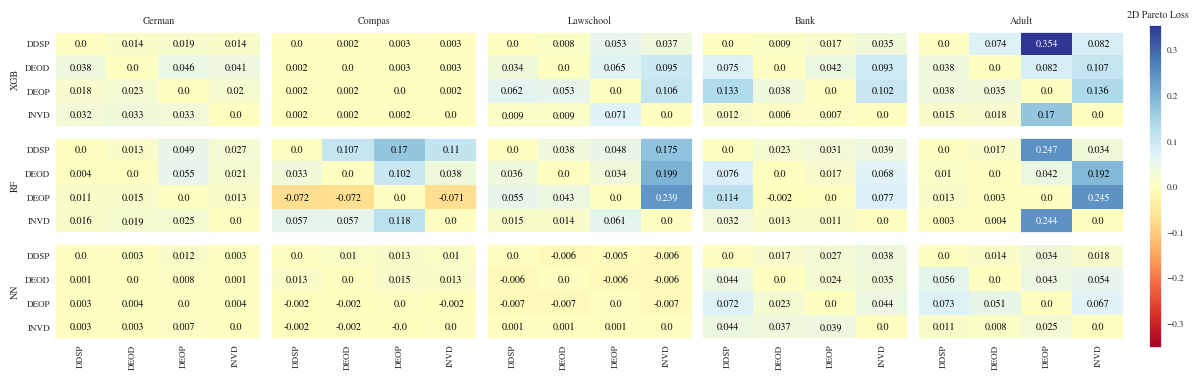

In [4]:
sns.set(font_scale=0.6)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=len(model_names), ncols=len(dataset_names), figsize=(2.5*len(dataset_names), 1.25*len(model_names)))

if len(model_names) == 1:
    axes = [axes]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette()

differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))
for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):

        difference = np.zeros((len(obj_names), len(obj_names)))

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names):
                    
                if obj_name1 == obj_name2:
                    difference[k1][k2] = 0
                    continue

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]

                obj_observations2 = many_experiments[('f1_comp', model, dataset)]['function_values'][val_keys+test_keys+['val_comp']]

                both_observations = pd.concat([obj_observations1, obj_observations2])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(obj_observations1[['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}', 'val_comp']].values)

                est_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}']].values).compute(ndr) / norm_factor

                difference[k1][k2] = true_hvol - est_hvol

        differences[i][j] = difference    

for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names): 

        im = axes[i][j].imshow(differences[i][j], vmin=-np.nanmax(differences), vmax=np.nanmax(differences), cmap='RdYlBu', aspect='auto')

        for k1, obj_name2 in enumerate(obj_names):
            for k2, obj_name2 in enumerate(obj_names):
                text = axes[i][j].text(k2, k1, np.around(differences[i][j], decimals=3)[k1][k2],
                       ha="center", va="center", color='white' if np.abs(differences[i][j][k1][k2]) > 0.2 else 'black')
        
        if i == 0:
            axes[i][j].set_title(f"{dataset.capitalize()}")
        
        if i == len(model_names)-1:
            axes[i][j].set_xticks(range(len(obj_names)))
            axes[i][j].set_xticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names], rotation=90)
        else:
            axes[i][j].set_xticks([])            
        if j == 0:
            axes[i][j].set_yticks(range(len(obj_names)))
            axes[i][j].set_yticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names])
            axes[i][j].set_ylabel(model.upper())
        else:
            axes[i][j].set_yticks([])
        
        axes[i][j].tick_params(which='both', size=0)
        axes[i][j].grid(False)

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.86])
cbar = fig.colorbar(im, cbar_ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(which='both', size=0)
cbar.ax.set_title('  2D Pareto Loss')

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq2/2D_pareto_loss.png', dpi=600)

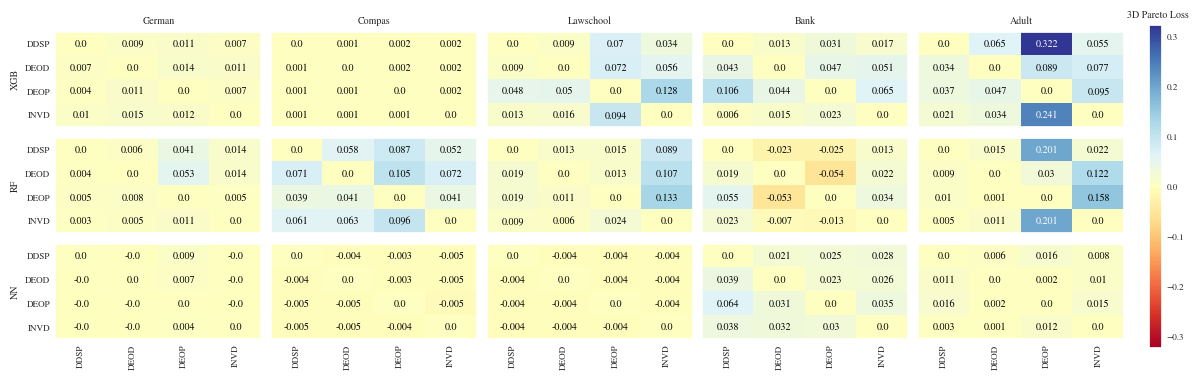

In [6]:
sns.set(font_scale=0.6)
sns.set_style({'font.family': 'STIXGeneral'})

fig, axes = plt.subplots(nrows=len(model_names), ncols=len(dataset_names), figsize=(2.5*len(dataset_names), 1.25*len(model_names)))

if len(model_names) == 1:
    axes = [axes]

val_keys = ['val_f1', 'val_ddsp', 'val_deod', 'val_deop', 'val_invd']
test_keys = ['test_f1', 'test_ddsp', 'test_deod', 'test_deop', 'test_invd']

obj_names = ['f1_ddsp', 'f1_deod', 'f1_deop', 'f1_invd']

colors = sns.color_palette()

differences = np.zeros((len(model_names), len(dataset_names), len(obj_names), len(obj_names)))
for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):

        many_observations = mo_experiments[('f1_multi', model, dataset)]['function_values'][val_keys+test_keys]

        difference = np.zeros((len(obj_names), len(obj_names)))

        observations = pd.DataFrame(columns=val_keys+test_keys)
        for k1, obj_name1 in enumerate(obj_names): 

            obj_keys1 = obj_name1.split('_')
            fair_key1 = obj_keys1[1]
            obj_observations1 = mo_experiments[(obj_name1, model, dataset)]['function_values'][val_keys+test_keys]

            for k2, obj_name2 in enumerate(obj_names):
                    
                if obj_name1 == obj_name2:
                    difference[k1][k2] = 0
                    continue

                obj_keys2 = obj_name2.split('_')
                fair_key2 = obj_keys2[1]

                obj_observations2 = many_experiments[('f1_comp', model, dataset)]['function_values'][val_keys+test_keys+['val_comp']]

                both_observations = pd.concat([obj_observations1, obj_observations2, many_observations])

                eps = 0.00000001
                ndr = np.array([np.max(both_observations[['val_f1']].values), np.max(both_observations[[f'val_{fair_key1}']].values), np.max(both_observations[[f'val_{fair_key2}']].values)]) + eps
                idl = np.array([np.min(both_observations[['val_f1']].values), np.min(both_observations[[f'val_{fair_key1}']].values), np.min(both_observations[[f'val_{fair_key2}']].values)]) - eps
                norm_factor = hypervolume([idl]).compute(ndr)

                true_hvol = hypervolume(many_observations[['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                pareto2_mask = is_pareto_front(obj_observations2[['val_f1', f'val_{fair_key2}', 'val_comp']].values)
                est_hvol = hypervolume(obj_observations2[pareto2_mask][['val_f1', f'val_{fair_key1}', f'val_{fair_key2}']].values).compute(ndr) / norm_factor

                difference[k1][k2] = true_hvol - est_hvol

        differences[i][j] = difference    

for i, model in enumerate(model_names):
    for j, dataset in enumerate(dataset_names): 

        im = axes[i][j].imshow(differences[i][j], vmin=-np.nanmax(differences), vmax=np.nanmax(differences), cmap='RdYlBu', aspect='auto')

        for k1, obj_name2 in enumerate(obj_names):
            for k2, obj_name2 in enumerate(obj_names):
                text = axes[i][j].text(k2, k1, np.around(differences[i][j], decimals=3)[k1][k2],
                       ha="center", va="center", color='white' if np.abs(differences[i][j][k1][k2]) > 0.2 else 'black')
        
        if i == 0:
            axes[i][j].set_title(f"{dataset.capitalize()}")
        
        if i == len(model_names)-1:
            axes[i][j].set_xticks(range(len(obj_names)))
            axes[i][j].set_xticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names], rotation=90)
        else:
            axes[i][j].set_xticks([])            
        if j == 0:
            axes[i][j].set_yticks(range(len(obj_names)))
            axes[i][j].set_yticklabels([obj_keys.split('_')[1].upper() for obj_keys in obj_names])
            axes[i][j].set_ylabel(model.upper())
        else:
            axes[i][j].set_yticks([])
        
        axes[i][j].tick_params(which='both', size=0)
        axes[i][j].grid(False)

fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.085, 0.01, 0.86])
cbar = fig.colorbar(im, cbar_ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(which='both', size=0)
cbar.ax.set_title('  3D Pareto Loss')

fig.savefig('/work/dlclarge2/robertsj-fairmohpo/figures/rq2/3D_pareto_loss.png', dpi=600)